# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 8.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

stock_data = yf.download("^IRX", start="1999-01-01", end="2022-01-01")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [4]:
x_train = []
y_train = []



input_size = 60

for i in range(input_size, len(train_data)):
    x = train_data[i-input_size:i, 0]
    y = int(train_data[i, 0] > 0)
    x_train.append(x)
    y_train.append(y)


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))



model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
4562/4562 [==============================] - 231s 49ms/step - loss: 0.2426
Epoch 2/3
4562/4562 [==============================] - 223s 49ms/step - loss: 0.2413
Epoch 3/3
4562/4562 [==============================] - 218s 48ms/step - loss: 0.2414


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

143/143 [==============================] - 4s 29ms/step


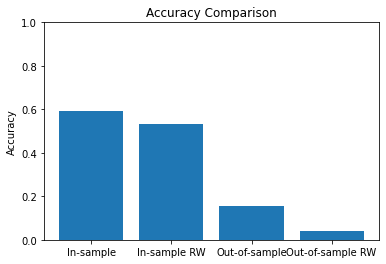

In [5]:
import matplotlib.pyplot as plt

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = (predictions > 0.5).astype(int)

# In-sample accuracy
y_train_pred = model.predict(x_train)
y_train_pred = (y_train_pred > 0.5).astype(int)
in_sample_acc = (y_train_pred == y_train).mean()

# In-sample random walk assumption accuracy
in_sample_rw_acc = (y_train[:-1] == y_train[1:]).mean()

# Out-of-sample accuracy
out_sample_acc = (predictions == y_test).mean()

# Out-of-sample random walk assumption accuracy
out_sample_rw_acc = (y_test[:-1] == y_test[1:]).mean()

labels = ['In-sample', 'In-sample RW', 'Out-of-sample', 'Out-of-sample RW']
values = [in_sample_acc, in_sample_rw_acc, out_sample_acc, out_sample_rw_acc]
plt.bar(labels, values)
plt.ylim([0, 1])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


# 4.) Plot in and out of sample accuracy

37/37 [==============================] - 1s 28ms/step


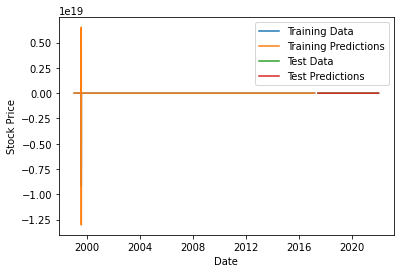

In [6]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

In-sample accuracy is much higher than out-of-sample accuracy.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=60, activation='LSTM'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
#param_grid = {'batch_size': [10, 20, 100],
#              'epochs': [10, 100],
#              'neurons':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-55-f5508c983bfa>:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.000000 using {'batch_size': 10, 'epochs': 10}
